In [67]:
from data.data_loader import load_dataset
x_train, y_train = load_dataset('./data/data.txt')

print("original data y_label distribution: ")
print("y = 1: ", len(y_train[y_train == 1]))
print("y = 2: ", len(y_train[y_train == 2]))
print("y = 3: ", len(y_train[y_train == 3]))

original data y_label distribution: 
y = 1:  70
y = 2:  70
y = 3:  70


### KMeans ++

In [68]:
import numpy as np

def initialize_centroids(X, k):
    # 随机选择第一个质心
    centroids = [X[np.random.choice(range(X.shape[0]))]]

    for _ in range(1, k):
        # 计算每个点到最近质心的距离
        dist_sq = np.array(
            [min([np.inner(c - x, c - x) for c in centroids]) for x in X]
        )
        probs = dist_sq / dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()

        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        centroids.append(X[i])

    return np.array(centroids)


def kmeans_pplus(X, k, max_iters=100):
    # 初始化质心
    centroids = initialize_centroids(X, k)

    for _ in range(max_iters):
        # 分配每个点到最近的质心
        clusters = [[] for _ in range(k)]
        for x in X:
            distances = [np.linalg.norm(x - c) for c in centroids]
            cluster = np.argmin(distances)
            clusters[cluster].append(x)

        # 计算新的 cluster 的中心
        new_centroids = [np.mean(cluster, axis=0) for cluster in clusters]

        # check whether converged
        if np.array_equal(centroids, new_centroids):
            print("Converged!")
            break

        centroids = new_centroids
        
    return centroids, clusters


# 使用示例
x_train, y_train = load_dataset("./data/data.txt")
k = 3  # 假设我们要分成3个簇
centroids, clusters = kmeans_pplus(x_train, k)

print("Centroids:", centroids)
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1} size: {len(cluster)}")

Converged!
Centroids: [array([18.72180328, 16.29737705,  0.88508689,  6.20893443,  3.72267213,
        3.60359016,  6.06609836]), array([11.96441558, 13.27480519,  0.8522    ,  5.22928571,  2.87292208,
        4.75974026,  5.08851948]), array([14.64847222, 14.46041667,  0.87916667,  5.56377778,  3.27790278,
        2.64893333,  5.19231944])]
Cluster 1 size: 61
Cluster 2 size: 77
Cluster 3 size: 72


### Soft K-Means

In [69]:
import numpy as np


def initialize_centroids(X, k):
    # 随机选择第一个质心
    centroids = [X[np.random.choice(range(X.shape[0]))]]

    for _ in range(1, k):
        # 计算每个点到最近质心的距离
        dist_sq = np.array(
            [min([np.inner(c - x, c - x) for c in centroids]) for x in X]
        )
        # 选择距离的平方作为权重进行随机选择
        probs = dist_sq / dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()

        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        centroids.append(X[i])

    return np.array(centroids)


def soft_kmeans(X, k, m=2, max_iters=100, tol=1e-4):
    # 初始化质心
    centroids = initialize_centroids(X, k)
    n_samples = X.shape[0]

    # 初始化隶属度矩阵
    U = np.random.dirichlet(np.ones(k), size=n_samples)

    for _ in range(max_iters):
        # 更新质心
        centroids = np.array(
            [
                np.sum((U[:, j] ** m).reshape(-1, 1) * X, axis=0) / np.sum(U[:, j] ** m)
                for j in range(k)
            ]
        )

        # 计算新的隶属度矩阵
        dist = np.array([[np.linalg.norm(x - c) for c in centroids] for x in X])
        new_U = 1 / (dist ** (2 / (m - 1)))
        new_U /= new_U.sum(axis=1, keepdims=True)

        # 检查收敛
        if np.linalg.norm(U - new_U) < tol:
            print("Converged!")
            break

        U = new_U

    return centroids, U


# 使用示例
x_train, y_train = load_dataset("./data/data.txt")
k = 3  # 假设我们要分成3个簇
centroids, U = soft_kmeans(x_train, k)

print("Centroids:", centroids)
for i in range(k):
    print(f"Cluster {i+1} size: {np.sum(U[:, i] > 0.5)}")

Converged!
Centroids: [[18.74886142 16.30506423  0.88547112  6.21346467  3.72646158  3.48489582
   6.06999419]
 [11.91127004 13.2642765   0.84961588  5.23259453  2.8577197   4.71675633
   5.09798913]
 [14.6030685  14.43585626  0.8794406   5.5569515   3.27282436  2.68280704
   5.18094302]]
Cluster 1 size: 60
Cluster 2 size: 75
Cluster 3 size: 67


### PCA

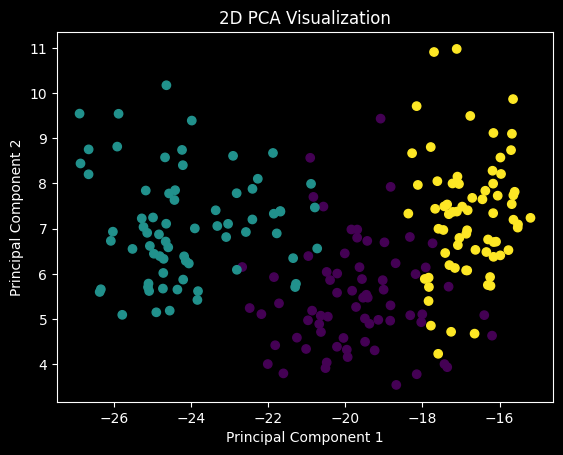

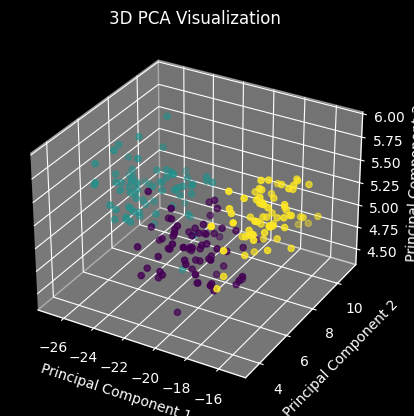

In [70]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None

    def fit(self, X):
        X_centralized = X - np.mean(X, axis=0)
        C = X_centralized.T @ X_centralized
        eig_vals, eig_vecs = np.linalg.eig(C)
        idx = np.argsort(eig_vals)[::-1]
        self.components = eig_vecs[:, idx[: self.n_components]]

    def transform(self, X):
        return X @ self.components

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


def visualize_2d(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D PCA Visualization")
    plt.show()


def visualize_3d(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("3D PCA Visualization")
    plt.show()


# 使用示例
x, y = load_dataset("./data/data.txt")

# 二维可视化
pca_model_2d = PCA(n_components=2)
X_pca_2d = pca_model_2d.fit_transform(x)
visualize_2d(X_pca_2d, y)

# 三维可视化
pca_model_3d = PCA(n_components=3)
X_pca_3d = pca_model_3d.fit_transform(x)
visualize_3d(X_pca_3d, y)

### nonelinear autoencoder

Epoch 0, Loss: 1.0000
Epoch 100, Loss: 0.9742
Epoch 200, Loss: 0.5046
Epoch 300, Loss: 0.4070
Epoch 400, Loss: 0.3722
Epoch 500, Loss: 0.3522
Epoch 600, Loss: 0.3374
Epoch 700, Loss: 0.3253
Epoch 800, Loss: 0.3135
Epoch 900, Loss: 0.2948
Epoch 1000, Loss: 0.2622
Epoch 1100, Loss: 0.2146
Epoch 1200, Loss: 0.1768
Epoch 1300, Loss: 0.1586
Epoch 1400, Loss: 0.1485
Epoch 1500, Loss: 0.1410
Epoch 1600, Loss: 0.1351
Epoch 1700, Loss: 0.1304
Epoch 1800, Loss: 0.1268
Epoch 1900, Loss: 0.1239
Epoch 2000, Loss: 0.1216
Epoch 2100, Loss: 0.1199
Epoch 2200, Loss: 0.1184
Epoch 2300, Loss: 0.1173
Epoch 2400, Loss: 0.1164
Epoch 2500, Loss: 0.1156
Epoch 2600, Loss: 0.1149
Epoch 2700, Loss: 0.1144
Epoch 2800, Loss: 0.1139
Epoch 2900, Loss: 0.1135
Epoch 3000, Loss: 0.1131
Epoch 3100, Loss: 0.1128
Epoch 3200, Loss: 0.1126
Epoch 3300, Loss: 0.1123
Epoch 3400, Loss: 0.1121
Epoch 3500, Loss: 0.1119
Epoch 3600, Loss: 0.1118
Epoch 3700, Loss: 0.1116
Epoch 3800, Loss: 0.1115
Epoch 3900, Loss: 0.1114
Epoch 4000, 

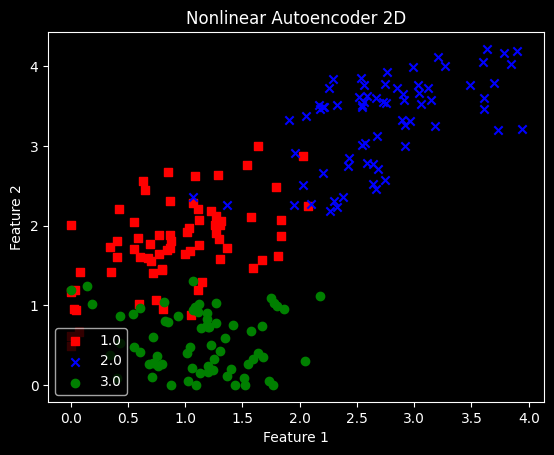

In [71]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NonlinearAutoencoder:
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.weights_encoder = np.random.randn(input_dim, encoding_dim) * 0.01
        self.bias_encoder = np.zeros((1, encoding_dim))
        self.weights_decoder = np.random.randn(encoding_dim, input_dim) * 0.01
        self.bias_decoder = np.zeros((1, input_dim))

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, X):
        self.encoded = self.relu(np.dot(X, self.weights_encoder) + self.bias_encoder)
        self.decoded = np.dot(self.encoded, self.weights_decoder) + self.bias_decoder
        return self.decoded

    def mse_loss(self, X, output):
        return np.mean((X - output) ** 2)

    def backward(self, X, output, lr):
        error = output - X
        d_weights_decoder = np.dot(self.encoded.T, error) / X.shape[0]
        d_bias_decoder = np.mean(error, axis=0)
        d_encoded = np.dot(error, self.weights_decoder.T)
        d_encoded[self.encoded <= 0] = 0  # ReLU的梯度
        d_weights_encoder = np.dot(X.T, d_encoded) / X.shape[0]
        d_bias_encoder = np.mean(d_encoded, axis=0)

        self.weights_encoder -= lr * d_weights_encoder
        self.bias_encoder -= lr * d_bias_encoder
        self.weights_decoder -= lr * d_weights_decoder
        self.bias_decoder -= lr * d_bias_decoder


X_train, y_train = load_dataset("./data/data.txt")
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

input_dim = X_train_std.shape[1]
encoding_dim = 2  # 将数据压缩到2维
autoencoder = NonlinearAutoencoder(input_dim, encoding_dim)

epochs = 7000
lr = 0.01

for epoch in range(epochs):
    output = autoencoder.forward(X_train_std)
    loss = autoencoder.mse_loss(X_train_std, output)
    autoencoder.backward(X_train_std, output, lr)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# 使用编码器进行降维
X_train_encoded = autoencoder.relu(
    np.dot(X_train_std, autoencoder.weights_encoder) + autoencoder.bias_encoder
)

X_reconstruct = autoencoder.forward(X_train_std)
reconstruction_error = np.mean((X_train_std - X_reconstruct) ** 2)
print(f"Reconstruction Error: {reconstruction_error:.4f}")

colors = ["r", "b", "g"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_encoded[y_train == l, 0],
        X_train_encoded[y_train == l, 1],
        c=c,
        label=l,
        marker=m,
    )

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Nonlinear Autoencoder 2D")
plt.legend(loc="lower left")
plt.show()

Epoch 0, Loss: 1.0002
Epoch 100, Loss: 0.9591
Epoch 200, Loss: 0.4716
Epoch 300, Loss: 0.2773
Epoch 400, Loss: 0.2407
Epoch 500, Loss: 0.2232
Epoch 600, Loss: 0.2116
Epoch 700, Loss: 0.2032
Epoch 800, Loss: 0.1955
Epoch 900, Loss: 0.1870
Epoch 1000, Loss: 0.1747
Epoch 1100, Loss: 0.1555
Epoch 1200, Loss: 0.1313
Epoch 1300, Loss: 0.1094
Epoch 1400, Loss: 0.0949
Epoch 1500, Loss: 0.0858
Epoch 1600, Loss: 0.0786
Epoch 1700, Loss: 0.0699
Epoch 1800, Loss: 0.0610
Epoch 1900, Loss: 0.0508
Epoch 2000, Loss: 0.0425
Epoch 2100, Loss: 0.0366
Epoch 2200, Loss: 0.0325
Epoch 2300, Loss: 0.0294
Epoch 2400, Loss: 0.0271
Epoch 2500, Loss: 0.0253
Epoch 2600, Loss: 0.0238
Epoch 2700, Loss: 0.0226
Epoch 2800, Loss: 0.0216
Epoch 2900, Loss: 0.0208
Epoch 3000, Loss: 0.0201
Epoch 3100, Loss: 0.0194
Epoch 3200, Loss: 0.0189
Epoch 3300, Loss: 0.0184
Epoch 3400, Loss: 0.0180
Epoch 3500, Loss: 0.0176
Epoch 3600, Loss: 0.0173
Epoch 3700, Loss: 0.0170
Epoch 3800, Loss: 0.0167
Epoch 3900, Loss: 0.0165
Epoch 4000, 

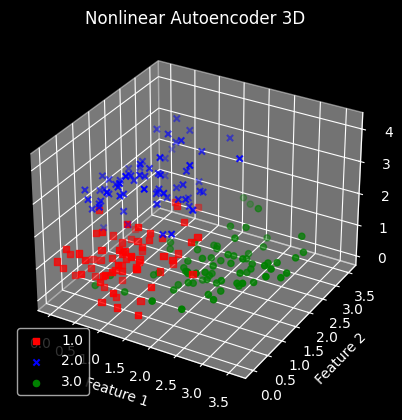

In [72]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


class NonlinearAutoencoder:
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.weights_encoder = np.random.randn(input_dim, encoding_dim) * 0.01
        self.bias_encoder = np.zeros((1, encoding_dim))
        self.weights_decoder = np.random.randn(encoding_dim, input_dim) * 0.01
        self.bias_decoder = np.zeros((1, input_dim))

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, X):
        self.encoded = self.relu(np.dot(X, self.weights_encoder) + self.bias_encoder)
        self.decoded = np.dot(self.encoded, self.weights_decoder) + self.bias_decoder
        return self.decoded

    def mse_loss(self, X, output):
        return np.mean((X - output) ** 2)

    def backward(self, X, output, lr):
        error = output - X
        d_weights_decoder = np.dot(self.encoded.T, error) / X.shape[0]
        d_bias_decoder = np.mean(error, axis=0)
        d_encoded = np.dot(error, self.weights_decoder.T)
        d_encoded[self.encoded <= 0] = 0  # ReLU的梯度
        d_weights_encoder = np.dot(X.T, d_encoded) / X.shape[0]
        d_bias_encoder = np.mean(d_encoded, axis=0)

        self.weights_encoder -= lr * d_weights_encoder
        self.bias_encoder -= lr * d_bias_encoder
        self.weights_decoder -= lr * d_weights_decoder
        self.bias_decoder -= lr * d_bias_decoder


# 加载数据函数
def load_dataset(file_path):
    data = np.loadtxt(file_path)
    X = data[:, :-1]
    y = data[:, -1]
    return X, y


X_train, y_train = load_dataset("./data/data.txt")
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

input_dim = X_train_std.shape[1]
encoding_dim = 3  # 将数据压缩到3维
autoencoder = NonlinearAutoencoder(input_dim, encoding_dim)

epochs = 7000
lr = 0.01

for epoch in range(epochs):
    output = autoencoder.forward(X_train_std)
    loss = autoencoder.mse_loss(X_train_std, output)
    autoencoder.backward(X_train_std, output, lr)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# 使用编码器进行降维
X_train_encoded = autoencoder.relu(
    np.dot(X_train_std, autoencoder.weights_encoder) + autoencoder.bias_encoder
)

X_reconstruct = autoencoder.forward(X_train_std)
reconstruction_error = np.mean((X_train_std - X_reconstruct) ** 2)
print(f"Reconstruction Error: {reconstruction_error:.4f}")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

colors = ["r", "b", "g"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(
        X_train_encoded[y_train == l, 0],
        X_train_encoded[y_train == l, 1],
        X_train_encoded[y_train == l, 2],
        c=c,
        label=l,
        marker=m,
    )

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Nonlinear Autoencoder 3D")
ax.legend(loc="lower left")
plt.show()

### K-Means++ soft K-means from PCA 

In [73]:
X_pca_2d

# 使用示例
# x_train, y_train = load_dataset("./data/data.txt")
k = 3  # 假设我们要分成3个簇
centroids, clusters = kmeans_pplus(X_pca_2d, k)

print("reduced dimension data from pca and cluster with kmeans++")
print("Centroids:", centroids)
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1} size: {len(cluster)}")

print("====================")
print("reduced dimension data from pca and cluster with soft-kmeans")

k = 3  # 假设我们要分成3个簇
centroids, U = soft_kmeans(X_pca_2d, k)

print("Centroids:", centroids)
for i in range(k):
    print(f"Cluster {i+1} size: {np.sum(U[:, i] > 0.5)}")

Converged!
reduced dimension data from pca and cluster with kmeans++
Centroids: [array([-24.53624924,   7.0685618 ]), array([-16.87197267,   7.24823234]), array([-20.08493809,   5.51698223])]
Cluster 1 size: 61
Cluster 2 size: 77
Cluster 3 size: 72
reduced dimension data from pca and cluster with soft-kmeans
Converged!
Centroids: [[-24.58499094   6.95807393]
 [-16.82775795   7.20041889]
 [-20.03654118   5.53919066]]
Cluster 1 size: 60
Cluster 2 size: 77
Cluster 3 size: 68


### K-Means++ soft K-means from AutoEncoder

In [74]:
X_pca_2d

# 使用示例
# x_train, y_train = load_dataset("./data/data.txt")
k = 3  # 假设我们要分成3个簇
centroids, clusters = kmeans_pplus(X_pca_2d, k)

print("Centroids:", centroids)
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1} size: {len(cluster)}")

print("====================")

k = 3  # 假设我们要分成3个簇
centroids, U = soft_kmeans(X_pca_2d, k)

print("Centroids:", centroids)
for i in range(k):
    print(f"Cluster {i+1} size: {np.sum(U[:, i] > 0.5)}")

Converged!
Centroids: [array([-24.53624924,   7.0685618 ]), array([-16.87197267,   7.24823234]), array([-20.08493809,   5.51698223])]
Cluster 1 size: 61
Cluster 2 size: 77
Cluster 3 size: 72
Converged!
Centroids: [[-16.82775583   7.20042495]
 [-20.03652896   5.53918659]
 [-24.58498646   6.95807343]]
Cluster 1 size: 77
Cluster 2 size: 68
Cluster 3 size: 60


### MLP 

data preprocessing： let the data distribution be unbias uniform distribution

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X, y = load_dataset("./data/data.txt")
# y = (y - 1).astype(int)
# y_one_hot = np.eye(3)[y]  # 转为 one-hot 编码

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Epoch 0, Loss: 0.9264694194409862
Epoch 100, Loss: 0.05308735798295997
Epoch 200, Loss: 0.03675603419997743
MLP for Multi-class Classification Accuracy: 0.35714285714285715


Text(0.5, 1.0, 'Loss Curve')

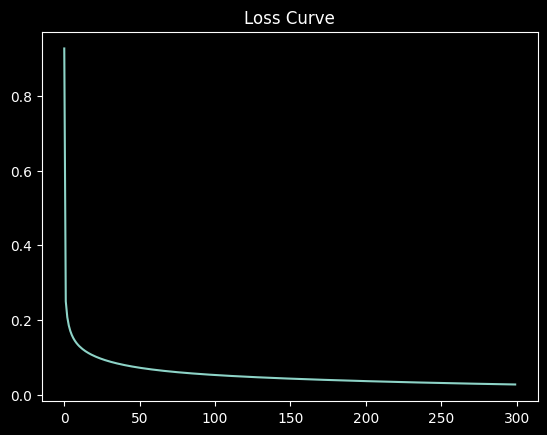

In [82]:
class MLP:
    def __init__(
        self, n_features, n_hidden, n_classes, learning_rate=0.01, epochs=1000
    ):
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights_input_hidden = np.random.randn(n_features, n_hidden)
        self.weights_hidden_output = np.random.randn(n_hidden, n_classes)
        self.bias_hidden = np.zeros((1, n_hidden))
        self.bias_output = np.zeros((1, n_classes))
        self.losses = []
        self.name = "MLP"

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def _cross_entropy_loss(self, y, y_pred):
        epsilon = 1e-15
        return -np.mean(
            y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon)
        )

    def fit(self, X, y):
        for epoch in range(self.epochs):
            # 前向传播
            hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
            hidden_output = self.sigmoid(hidden_input)
            final_input = (
                np.dot(hidden_output, self.weights_hidden_output) + self.bias_output
            )
            final_output = self.softmax(final_input)

            loss = self._cross_entropy_loss(y, final_output)
            self.losses.append(loss)

            # backpropogation
            error_output = final_output - y
            error_hidden = np.dot(
                error_output, self.weights_hidden_output.T
            ) * self.sigmoid_derivative(hidden_output)

            # 更新权重和偏置
            self.weights_hidden_output -= self.learning_rate * np.dot(
                hidden_output.T, error_output
            )
            self.bias_output -= self.learning_rate * np.sum(
                error_output, axis=0, keepdims=True
            )
            self.weights_input_hidden -= self.learning_rate * np.dot(X.T, error_hidden)
            self.bias_hidden -= self.learning_rate * np.sum(
                error_hidden, axis=0, keepdims=True
            )

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        hidden_output = self.sigmoid(hidden_input)
        final_input = (
            np.dot(hidden_output, self.weights_hidden_output) + self.bias_output
        )
        final_output = self.softmax(final_input)
        return np.argmax(final_output, axis=1) + 1

    def predict_binary(self, X):
        hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        hidden_output = self.sigmoid(hidden_input)
        final_input = (
            np.dot(hidden_output, self.weights_hidden_output) + self.bias_output
        )
        final_output = self.softmax(final_input)
        predictions = np.argmax(final_output, axis=1)
        predictions = np.where(predictions == 0, -1, 1)
        return predictions


encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
n_features = X_train.shape[1]
n_hidden = 16
n_classes = len(np.unique(y_train))
mlp = MLP(n_features, n_hidden, n_classes, learning_rate=0.01, epochs=300)
mlp.fit(X_train, y_train_onehot)
y_pred = mlp.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'MLP for Multi-class Classification Accuracy: {accuracy}')

import matplotlib.pyplot as plt

plt.plot(mlp.losses)
plt.title("Loss Curve")

### SVM

svm source code

In [77]:
from lec11_svm.svc import BiLinearSVC, BiKernelSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X, y = load_dataset("./data/data.txt")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
index_2 = np.where(y_train == 2)
X_train = np.delete(X_train, index_2, axis=0)
y_train = np.delete(y_train, index_2)
index_2 = np.where(y_test == 2)
X_test = np.delete(X_test, index_2, axis=0)
y_test = np.delete(y_test, index_2, axis=0)

y_train[y_train == 3] = -1
y_test[y_test == 3] = -1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
clf = BiLinearSVC().fit(X_train, y_train)
y_pred = clf.decision_function(X_test)
y_pred = np.where(y_pred > 0, 1, -1)
print(f"svm binary classification Accuracy: {np.mean(y_pred == y_test)}")

svm binary classification Accuracy: 0.8571428571428571


In [79]:
clf = BiKernelSVC().fit(X_train, y_train)
y_pred = clf.decision_function(X_test)
y_pred = np.where(y_pred > 0, 1, -1)
print(f"svm with gaussain kernel Accuracy: {np.mean(y_pred == y_test)}")

svm with gaussain kernel Accuracy: 0.8928571428571429


### ADAboost

In [ ]:
# 初始化权重
from lec11_svm.svc import BiLinearSVC, BiKernelSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X, y = load_dataset("./data/data.txt")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
index_2 = np.where(y_train == 2)
X_train = np.delete(X_train, index_2, axis=0)
y_train = np.delete(y_train, index_2)
index_2 = np.where(y_test == 2)
X_test = np.delete(X_test, index_2, axis=0)
y_test = np.delete(y_test, index_2, axis=0)

y_train[y_train == 3] = -1
y_test[y_test == 3] = -1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


n_samples, n_features = X_train.shape
w = np.ones(n_samples) / n_samples

class WeakDecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_index]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions


# train weak classifiers and ensemble
def adaboost(X, y, n_clf, w):
    clfs = []
    for _ in range(n_clf):
        clf = WeakDecisionStump()
        min_error = float("inf")
        for feature_i in range(n_features):
            X_column = X[:, feature_i]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                p = 1
                predictions = np.ones(n_samples)
                predictions[X_column < threshold] = -1
                misclassified = w[y != predictions]
                error = sum(misclassified)
                if error > 0.5:
                    error = 1 - error
                    p = -1
                if error < min_error:
                    clf.polarity = p
                    clf.threshold = threshold
                    clf.feature_index = feature_i
                    min_error = error
        EPS = 1e-10
        clf.alpha = 0.5 * np.log((1 - min_error) / (min_error + EPS))
        predictions = clf.predict(X)
        w *= np.exp(-clf.alpha * y * predictions)
        w /= np.sum(w)
        clfs.append(clf)
    return clfs

# 预测
def predict(X, clfs):
    clf_preds = [clf.alpha * clf.predict(X) for clf in clfs]
    y_pred = np.sum(clf_preds, axis=0)
    y_pred = np.sign(y_pred)
    return y_pred

n_clf = 25
clfs = adaboost(X_train, y_train, n_clf, w)

y_pred = predict(X_test, clfs)

accuracy = np.mean(y_pred == y_test)
print(f"ensemble Accuracy: {accuracy * 100:.2f}%")
y_pred

ensemble Accuracy: 85.71%


array([ 1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,
        1., -1.])